In [8]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Ensuring consistency in TensorFlow imports
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Optional, to suppress TensorFlow warnings

# Display versions to confirm installations (optional but useful)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"TensorFlow version: {tf.__version__}")


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:

data = pd.read_csv("C:/Users/avani/Downloads/traffic_info.csv")
data.head()


,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:10:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [ ]:
# Import necessary libraries
import pandas as pd

# Load the data
data = pd.read_csv("C:/Users/avani/Downloads/traffic_info.csv")

def clean_data(data):
    # Display initial data
    print(data.head())
    print(data.columns)

    # Trim any leading or trailing spaces in column names
    data.columns = data.columns.str.strip()

    # Check for invalid dates
    print("Checking for invalid dates...")
    invalid_dates = data[~pd.to_datetime(data['Date'], errors='coerce').notnull()]
    if not invalid_dates.empty:
        print("Invalid dates found:")
        print(invalid_dates)
    else:
        print("No invalid dates found.")

    # Check for invalid times
    print("Checking for invalid times...")
    invalid_times = data[~pd.to_datetime(data['Time'], format='%I:%M:%S %p', errors='coerce').notnull()]
    if not invalid_times.empty:
        print("Invalid times found:")
        print(invalid_times)
    else:
        print("No invalid times found.")

    # Remove invalid rows
    data = data[pd.to_datetime(data['Date'], errors='coerce').notnull()]
    data = data[pd.to_datetime(data['Time'], format='%I:%M:%S %p', errors='coerce').notnull()]

    # Combine 'Date' and 'Time' into 'DateTime'
    data['DateTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

    # Drop 'ID' column if it exists
    data = data.drop(columns=['ID'], errors='ignore')

    # Display DataFrame information
    data.info()

    # Convert vehicle count columns to numeric
    vehicle_columns = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
    for col in vehicle_columns:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        else:
            print(f"Error: '{col}' column is missing")

    # Calculate total vehicle count
    if all(col in data.columns for col in vehicle_columns):
        data['Total'] = data[vehicle_columns].sum(axis=1)
    else:
        print("Error: One or more vehicle count columns are missing")

    # Display final DataFrame information
    data.info()
    return data

# Clean the data

C:\Users\avani\AppData\Local\Temp\ipykernel_3896\2661641100.py:23: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  Time_series = sns.lineplot(x='DateTime', y='Total', data=data, hue='Traffic Situation', palette=colors)


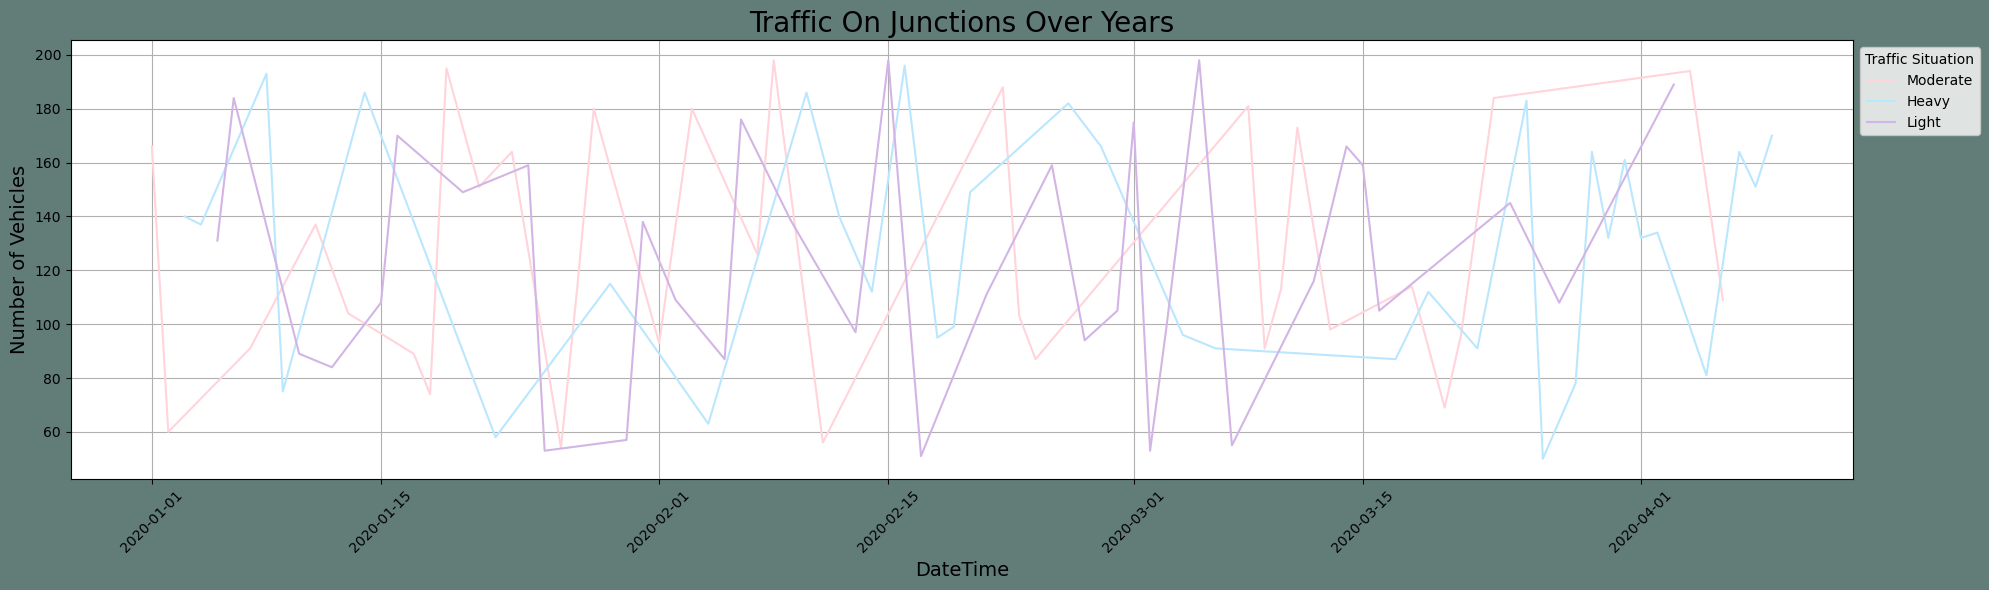

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data creation (replace this with your actual data)
# data = pd.read_csv('your_data.csv')  # Load your data here
# For demonstration, let's create a sample DataFrame
data = pd.DataFrame({
    'DateTime': pd.date_range(start='2020-01-01', periods=100, freq='D'),
    'Total': np.random.randint(50, 200, size=100),
    'Traffic Situation': np.random.choice(['Heavy', 'Moderate', 'Light'], size=100)
})

# Define the color palette
colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]

# Create the figure and axis
plt.figure(figsize=(20, 6), facecolor="#627D78")

# Check if required columns exist and data is not empty
if not data.empty and all(col in data.columns for col in ['DateTime', 'Total', 'Traffic Situation']):
    # Create the line plot
    Time_series = sns.lineplot(x='DateTime', y='Total', data=data, hue='Traffic Situation', palette=colors)

    # Set the title and labels
    Time_series.set_title("Traffic On Junctions Over Years", fontsize=20)
    Time_series.set_ylabel("Number of Vehicles", fontsize=14)
    Time_series.set_xlabel("DateTime", fontsize=14)

    # Improve x-axis date formatting
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(True)  # Add grid lines for better visualization

    # Adjust legend position
    plt.legend(title='Traffic Situation', loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()
else:
    print("Data is empty or required columns are missing.")

In [ ]:
# Ensure the 'DateTime' column exists
if 'DateTime' not in data.columns:
    raise ValueError("Error: 'DateTime' column is missing in the DataFrame.")

# Define new features and their corresponding extraction methods
new_features = {
    "Year": lambda x: x.dt.year,
    "Month": lambda x: x.dt.month,
    "Date_no": lambda x: x.dt.day,
    "Hour": lambda x: x.dt.hour,
    "Day": lambda x: x.dt.strftime("%A"),
    "Month_Name": lambda x: x.dt.strftime("%B")
}

# Loop through the dictionary to create new columns if they don't already exist
for feature, extraction in new_features.items():
    if feature not in data.columns:
        data[feature] = extraction(data['DateTime'])

# Display the first few rows to verify the new columns have been added
print("New features added to the DataFrame:")
print(data.head())

New features added to the DataFrame:
    DateTime  Total Traffic Situation  Year  Month  Date_no  Hour        Day  \
0 2020-01-01    166          Moderate  2020      1        1     0  Wednesday   
1 2020-01-02     60          Moderate  2020      1        2     0   Thursday   
2 2020-01-03    140             Heavy  2020      1        3     0     Friday   
3 2020-01-04    137             Heavy  2020      1        4     0   Saturday   
4 2020-01-05    131             Light  2020      1        5     0     Sunday   

  Month_Name  
0    January  
1    January  
2    January  
3    January  
4    January  


C:\Users\avani\AppData\Local\Temp\ipykernel_3896\2695409240.py:2: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(x=data[feature], y="Total", data=data, hue="Traffic Situation", palette=colors)


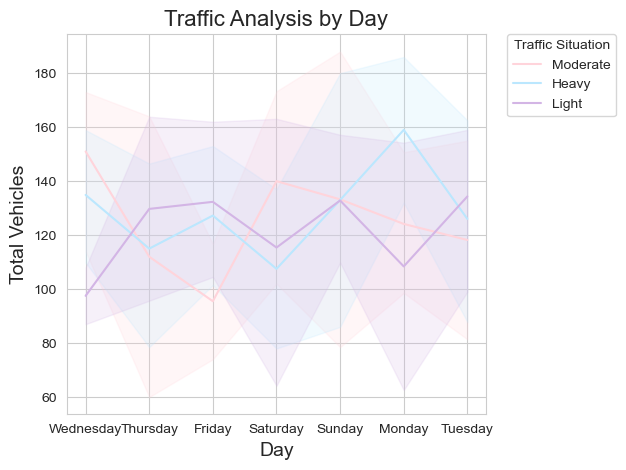

In [ ]:
# Create the line plot
sns.lineplot(x=data[feature], y="Total", data=data, hue="Traffic Situation", palette=colors)

# Set title and labels
plt.title(f"Traffic Analysis by {feature}", fontsize=16)
plt.xlabel(feature, fontsize=14)
plt.ylabel("Total Vehicles", fontsize=14)
plt.legend(title='Traffic Situation', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add grid lines
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\avani\AppData\Local\Temp\ipykernel_3896\3711554722.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2020-01-01 00:00", periods=24, freq='H')  # Generate hourly data for one day


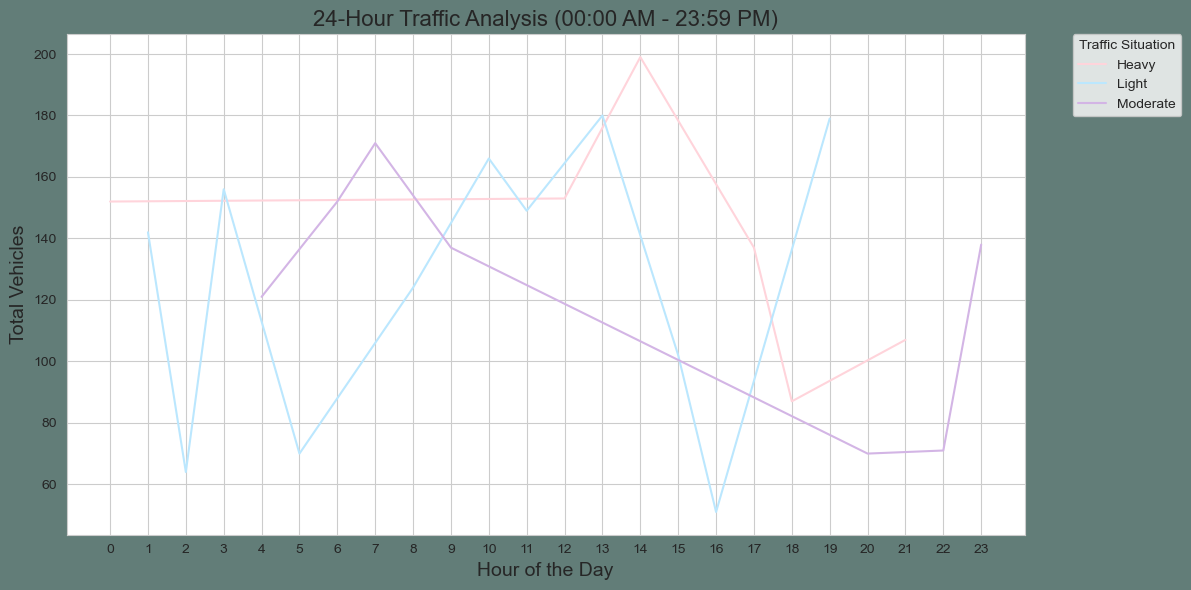

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample Data Generation
np.random.seed(42)  # For reproducibility
dates = pd.date_range(start="2020-01-01 00:00", periods=24, freq='H')  # Generate hourly data for one day
data = pd.DataFrame({
    'DateTime': dates,
    'Total': np.random.randint(50, 200, size=len(dates)),  # Random total vehicle counts
    'Traffic Situation': np.random.choice(['Heavy', 'Moderate', 'Light'], size=len(dates))  # Random traffic situation
})

# Ensure DateTime is in datetime format
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Extracting features from DateTime
data["Year"] = data['DateTime'].dt.year
data["Month"] = data['DateTime'].dt.month
data["Date_no"] = data['DateTime'].dt.day
data["Hour"] = data['DateTime'].dt.hour
data["Day"] = data['DateTime'].dt.strftime("%A")

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define colors for the plots
colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5"]

def plot_daily_traffic_analysis(data, colors):
    """Function to plot traffic analysis for a full day (00:00 AM to 23:59 PM)."""
    plt.figure(figsize=(12, 6), facecolor="#627D78")
    
    # Create the line plot
    sns.lineplot(x='Hour', y='Total', data=data, hue='Traffic Situation', palette=colors)
    
    # Set title and labels
    plt.title("24-Hour Traffic Analysis (00:00 AM - 23:59 PM)", fontsize=16)
    plt.xlabel("Hour of the Day", fontsize=14)
    plt.ylabel("Total Vehicles", fontsize=14)
    plt.xticks(range(0, 24))  # Set x-ticks for hours 0-23
    plt.legend(title='Traffic Situation', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Add grid lines
    plt.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot the daily traffic analysis
plot_daily_traffic_analysis(data, colors)


C:\Users\avani\AppData\Local\Temp\ipykernel_3896\438784848.py:24: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  count = sns.countplot(data=data, x="Year", hue="Junction", palette=colors)
C:\Users\avani\AppData\Local\Temp\ipykernel_3896\438784848.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  count.set_xticklabels(count.get_xticklabels(), rotation=45, fontsize=12, color='white')


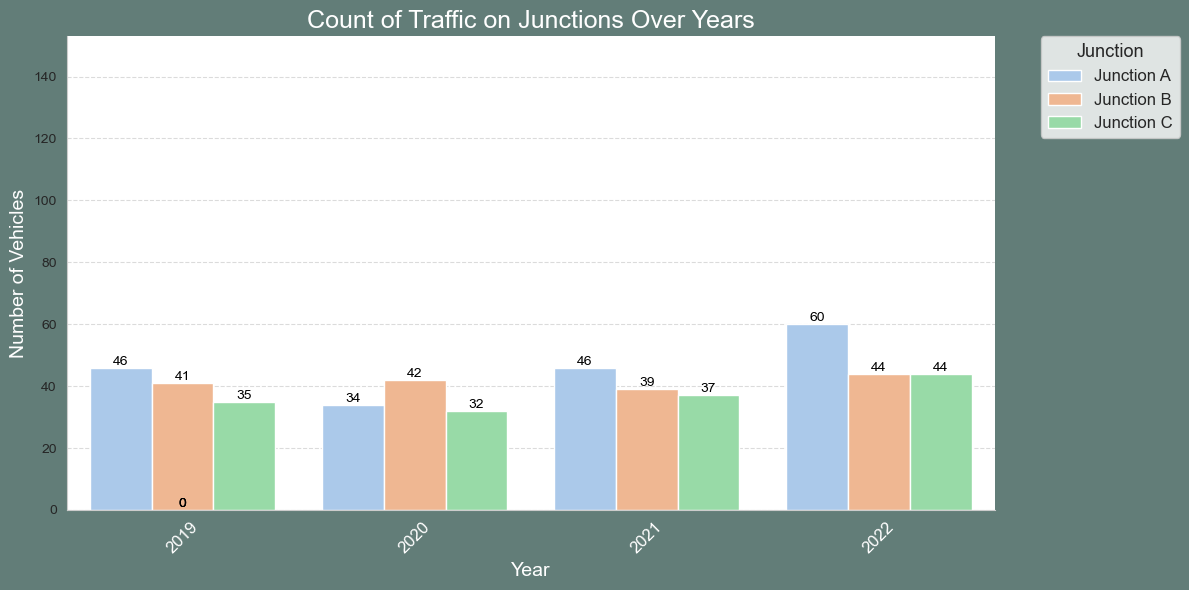

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame for demonstration purposes
import pandas as pd
import numpy as np

# Sample data creation (replace this with your actual data)
np.random.seed(42)
data = pd.DataFrame({
    'Year': np.random.choice([2019, 2020, 2021, 2022], size=500),
    'Junction': np.random.choice(['Junction A', 'Junction B', 'Junction C'], size=500)
})

# Ensure the 'Junction' column exists
if 'Junction' not in data.columns:
    raise ValueError("Missing required column 'Junction' in the DataFrame.")

# Set the figure size and background color
plt.figure(figsize=(12, 6), facecolor="#627D78")  # Increased height for better visibility

# Create a count plot
colors = sns.color_palette("pastel")  # Use a pastel color palette for better aesthetics
count = sns.countplot(data=data, x="Year", hue="Junction", palette=colors)

# Set the title and labels
count.set_title("Count of Traffic on Junctions Over Years", fontsize=18, color='white')
count.set_ylabel("Number of Vehicles", fontsize=14, color='white')
count.set_xlabel("Year", fontsize=14, color='white')

# Improve x-tick labels for better visibility
count.set_xticklabels(count.get_xticklabels(), rotation=45, fontsize=12, color='white')

# Adjust legend position and style
plt.legend(title='Junction', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12, title_fontsize='13')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits for better visual comparison
plt.ylim(0, data['Year'].value_counts().max() + 5)  # Adjust the limit based on your data

# Add value labels on top of the bars
for p in count.patches:
    count.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', color='black', fontsize=10)

# Improve the overall aesthetics
sns.despine()  # Remove top and right spines for a cleaner look

# Show the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()

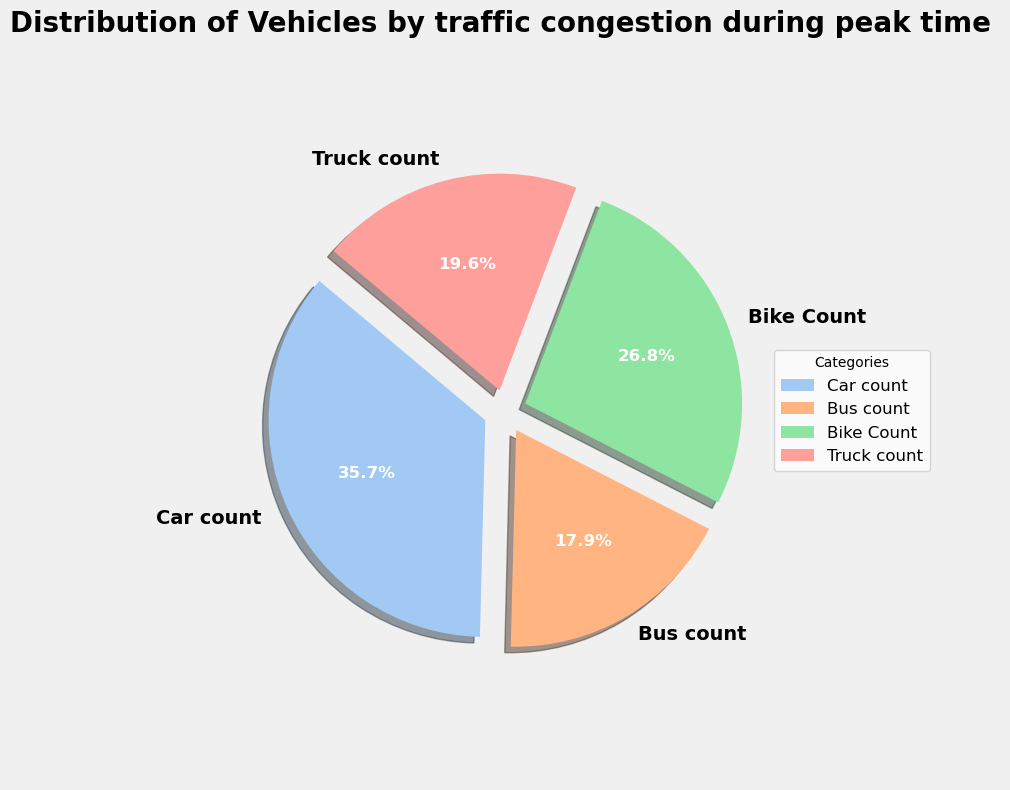

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a pie chart
def create_pie_chart(data, labels, title):
    # Ensure the data is in the correct format
    if len(data) != len(labels):
        raise ValueError("Data and labels must have the same length.")
    
    # Define a color palette
    colors = sns.color_palette("pastel", len(labels))

    # Create the pie chart
    plt.figure(figsize=(8, 8), facecolor="#f0f0f0")
    wedges, texts, autotexts = plt.pie(
        data,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        shadow=True,
        explode=[0.1] * len(labels)  # Slightly explode each slice for emphasis
    )

    # Customize the font properties
    plt.setp(texts, size=14, weight='bold', color='black')  # Set label text properties
    plt.setp(autotexts, size=12, weight='bold', color='white')  # Set percentage text properties

    plt.title(title, fontsize=20, weight='bold', color='black')
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

    # Add a legend
    plt.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

    # Show the plot
    plt.tight_layout()  # Adjust layout to fit elements
    plt.show()

# Example usage
if __name__ == "__main__":
    # Input your own data here
    data = [200, 100, 150, 110 ]  # Replace with your own data
    labels = ['Car count ', 'Bus count ', 'Bike Count', 'Truck count']  # Replace with your own labels
    title = "Distribution of Vehicles by traffic congestion during peak time "  # Replace with your own title

    # Create the pie chart
    create_pie_chart(data, labels, title)

    data = [200, 100, 150, 110]  # Your own data values
    labels = ['Car count', 'Bus count', 'Bike count', 'Truck count']  # Your own labels
    title = "My Custom Pie Chart"  # Your own title

In [8]:
import pandas as pd

def load_data(file_path):
    """
    Load data from a CSV file.

    Parameters:
    - file_path: Path to the CSV file.

    Returns:
    - DataFrame containing the data from the CSV file or None if an error occurs.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: There was a problem parsing the file.")
    return None

def create_pivot_table(data, value_column, index_column, columns_column, aggfunc='mean'):
    """
    Create a pivot table from the DataFrame.

    Parameters:
    - data: DataFrame to pivot.
    - value_column: Column to aggregate.
    - index_column: Column to use as index.
    - columns_column: Column to use as columns.
    - aggfunc: Aggregation function to use.

    Returns:
    - Pivot table DataFrame.
    """
    return data.pivot_table(values=value_column, index=index_column, columns=columns_column, aggfunc=aggfunc)

def main():
    # Load data from a CSV file
    file_path = input("Enter the path to your CSV file: ")
    data = load_data(file_path)

    if data is not None:
        # Ensure 'DateTime' is in datetime format
        if 'DateTime' in data.columns:
            data['DateTime'] = pd.to_datetime(data['DateTime'])
        else:
            print("Error: 'DateTime' column not found in the DataFrame.")
            return

        # Specify the parameters for the pivot table
        value_column = 'value'  # Column to aggregate
        index_column = 'DateTime'  # Column to use as index
        columns_column = 'parameters'  # Column to use as columns

        # Create the pivot table
        df_J = create_pivot_table(data, value_column, index_column, columns_column)

        # Display the shape and descriptive statistics of the pivot table
        print(f"Pivot table shape: {df_J.shape}")
        print("Pivot table descriptive statistics:")
        print(df_J.describe())

if __name__ == "__main__":
    main()

OSError: [Errno 22] Invalid argument: '"C:/Users/avani/Downloads/traffic_info.csv"'

In [12]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")

def load_data(file_path):
    """Load data from a CSV file."""
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(data):
    """Preprocess the data by cleaning and combining date and time."""
    # Trim any leading or trailing spaces in column names
    data.columns = data.columns.str.strip()

    # Check for invalid dates and times
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data['Time'] = pd.to_datetime(data['Time'], format='%I:%M:%S %p', errors='coerce').dt.time

    # Remove rows with invalid dates or times
    data = data.dropna(subset=['Date', 'Time'])

    # Combine 'Date' and 'Time' into 'DateTime'
    data['DateTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

    # Drop 'ID' column if it exists
    data = data.drop(columns=['ID'], errors='ignore')

    return data

def convert_vehicle_counts(data, vehicle_columns):
    """Convert vehicle count columns to numeric and calculate total."""
    for col in vehicle_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Calculate total vehicles
    data['Total'] = data[vehicle_columns].sum(axis=1)
    return data

def plot_traffic_over_years(data):
    """Plot traffic over the years."""
    colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]
    plt.figure(figsize=(20, 4), facecolor="#627D78")
    sns.lineplot(x=data['DateTime'], y="Total", data=data, hue="Traffic Situation", palette=colors)
    plt.title("Traffic On Junctions Over Years")
    plt.ylabel("Number of Vehicles")
    plt.xlabel("Date")
    plt.show()

def create_new_features(data):
    """Create new time-based features."""
    data["Year"] = data['DateTime'].dt.year
    data["Month"] = data['DateTime'].dt.month
    data["Date_no"] = data['DateTime'].dt.day
    data["Hour"] = data['DateTime'].dt.hour
    data["Day"] = data['DateTime'].dt.strftime("%A")
    return data

def plot_traffic_analysis(data, feature):
    """Plot traffic analysis based on a specific feature."""
    colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]
    plt.figure(figsize=(10, 2), facecolor="#627D78")
    sns.lineplot(x=data[feature], y="Total", data=data, hue="Traffic Situation", palette=colors)
    plt.title(f"Traffic Analysis by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Total Vehicles")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def plot_junction_counts(data):
    """Plot count of traffic on junctions over years."""
    plt.figure(figsize=(12, 5), facecolor="#627D78")
    sns.countplot(data=data, x="Year", hue="Junction", palette="pastel")
    plt.title("Count Of Traffic On Junctions Over Years")
    plt.ylabel("Number of Vehicles")
    plt.xlabel("Year")
    plt.show()

def plot_correlation_matrix(data):
    """Plot correlation matrix and pairplot."""
    plt.figure(figsize_)

In [9]:
 #Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [14]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")

def load_data(file_path):
    """Load data from a CSV file."""
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(data):
    """Preprocess the data by cleaning and combining date and time."""
    # Trim any leading or trailing spaces in column names
    data.columns = data.columns.str.strip()

    # Check for invalid dates and times
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data['Time'] = pd.to_datetime(data['Time'], format='%I:%M:%S %p', errors='coerce').dt.time

    # Remove rows with invalid dates or times
    data = data.dropna(subset=['Date', 'Time'])

    # Combine 'Date' and 'Time' into 'DateTime'
    data['DateTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

    # Drop 'ID' column if it exists
    data = data.drop(columns=['ID'], errors='ignore')

    return data

def convert_vehicle_counts(data, vehicle_columns):
    """Convert vehicle count columns to numeric and calculate total."""
    for col in vehicle_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Calculate total vehicles
    data['Total'] = data[vehicle_columns].sum(axis=1)
    return data

def plot_traffic_over_years(data):
    """Plot traffic over the years."""
    colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]
    plt.figure(figsize=(20, 4), facecolor="#627D78")
    sns.lineplot(x=data['DateTime'], y="Total", data=data, hue="Traffic Situation", palette=colors)
    plt.title("Traffic On Junctions Over Years")
    plt.ylabel("Number of Vehicles")
    plt.xlabel("Date")
    plt.show()

def create_new_features(data):
    """Create new time-based features."""
    data["Year"] = data['DateTime'].dt.year
    data["Month"] = data['DateTime'].dt.month
    data["Date_no"] = data['DateTime'].dt.day
    data["Hour"] = data['DateTime'].dt.hour
    data["Day"] = data['DateTime'].dt.strftime("%A")
    return data

def plot_traffic_analysis(data, feature):
    """Plot traffic analysis based on a specific feature."""
    colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]
    plt.figure(figsize=(10, 2), facecolor="#627D78")
    sns.lineplot(x=data[feature], y="Total", data=data, hue="Traffic Situation", palette=colors)
    plt.title(f"Traffic Analysis by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Total Vehicles")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def plot_junction_counts(data):
    """Plot count of traffic on junctions over years."""
    plt.figure(figsize=(12, 5), facecolor="#627D78")
    sns.countplot(data=data, x="Year", hue="Junction", palette="pastel")
    plt.title("Count Of Traffic On Junctions Over Years")
    plt.ylabel("Number of Vehicles")
    plt.xlabel("Year")
    plt.show()

def plot_correlation_matrix(data):
    """Plot correlation matrix and pairplot."""
    plt.figure(figsize)